In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [5]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)




CPU times: user 1.64 s, sys: 2.37 s, total: 4.01 s
Wall time: 4.01 s


In [6]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [7]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [8]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
y = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(y+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 10.9 s, sys: 2.65 s, total: 13.5 s
Wall time: 13.6 s


# clusterings

In [10]:
# adata = anndata.AnnData(X=y, obs=ref_data.obs)
# sc.tl.pca(adata, svd_solver='arpack') # with or without PCs
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [11]:
# # resolutions = [1, 10, 100]#, 1000, 10000]
# # resolutions = [1000, 10000]
# # resolutions = [200, 500, 2000, 5000]
# resolutions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

# adata.uns['resolutions'] = np.array(resolutions)

# for r in tqdm.tqdm(resolutions):
#     col = f'leiden_r{r}'
#     sc.tl.leiden(adata, resolution=r, key_added=col)
#     eta2, SSt, SSb = anova_eta2(y, adata.obs[col].values)
#     adata.var[f'eta2_{col}'] = eta2
#     adata.var[f'SSt_{col}'] = SSt
#     adata.var[f'SSb_{col}'] = SSb 
    
#     nclst = len(np.unique(adata.obs[col].values))
#     print(r, nclst)
    
#     # break

In [13]:
# %%time
# # save results (adata res)
# output = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
# adata.write(output)

In [ ]:
# eta results -- used below; naming is bad for historical reasons
eta2_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
adata = anndata.read_h5ad(eta2_path)
adata

# eta2 allen

In [14]:
%%time
eta2_c1, SSt_c1, SSb_c1 = anova_eta2(y, ref_data.obs['Level_1_class_label'].values)
eta2_c2, SSt_c2, SSb_c2 = anova_eta2(y, ref_data.obs['Level_2_neighborhood_label'].values)
eta2_c3, SSt_c3, SSb_c3 = anova_eta2(y, ref_data.obs['Level_3_subclass_label'].values)
eta2_c5, SSt_c5, SSb_c5 = anova_eta2(y, ref_data.obs['Level_5_cluster_label'].values)

nclst_c1 = len(np.unique(ref_data.obs['Level_1_class_label'].values))
nclst_c2 = len(np.unique(ref_data.obs['Level_2_neighborhood_label'].values))
nclst_c3 = len(np.unique(ref_data.obs['Level_3_subclass_label'].values))
nclst_c5 = len(np.unique(ref_data.obs['Level_5_cluster_label'].values))

allen_eta2s = [eta2_c1, eta2_c2, eta2_c3, eta2_c5]
allen_overall_scores = [
    SSb_c1.sum()/SSt_c1.sum(), 
    SSb_c2.sum()/SSt_c2.sum(), 
    SSb_c3.sum()/SSt_c3.sum(), 
    SSb_c5.sum()/SSt_c5.sum(), 
   ]
allen_nclsts = [nclst_c1, nclst_c2, nclst_c3, nclst_c5]

CPU times: user 1min, sys: 8.97 s, total: 1min 9s
Wall time: 1min 9s


# visualize

In [15]:
cols = np.sort(adata.obs.filter(regex='^leiden_r').columns) #['eta2_lenden_r']
resolutions = np.array([float(col[len('leiden_r'):]) for col in cols])

idx = np.argsort(resolutions)
cols = cols[idx]
resolutions = resolutions[idx]

etas = []
overall_scores = []
labels = []
nclsts = []

for col in cols:
    # col = f'leiden_r{r}'
    eta2 = adata.var[f'eta2_{col}'].values
    SSb = adata.var[f'SSb_{col}'].values
    SSt = adata.var[f'SSt_{col}'].values
    nclst = len(np.unique(adata.obs[col].values))
    
    etas.append(np.sqrt(eta2))
    overall_scores.append(SSb.sum()/SSt.sum())
    labels.append(col)
    nclsts.append(nclst)

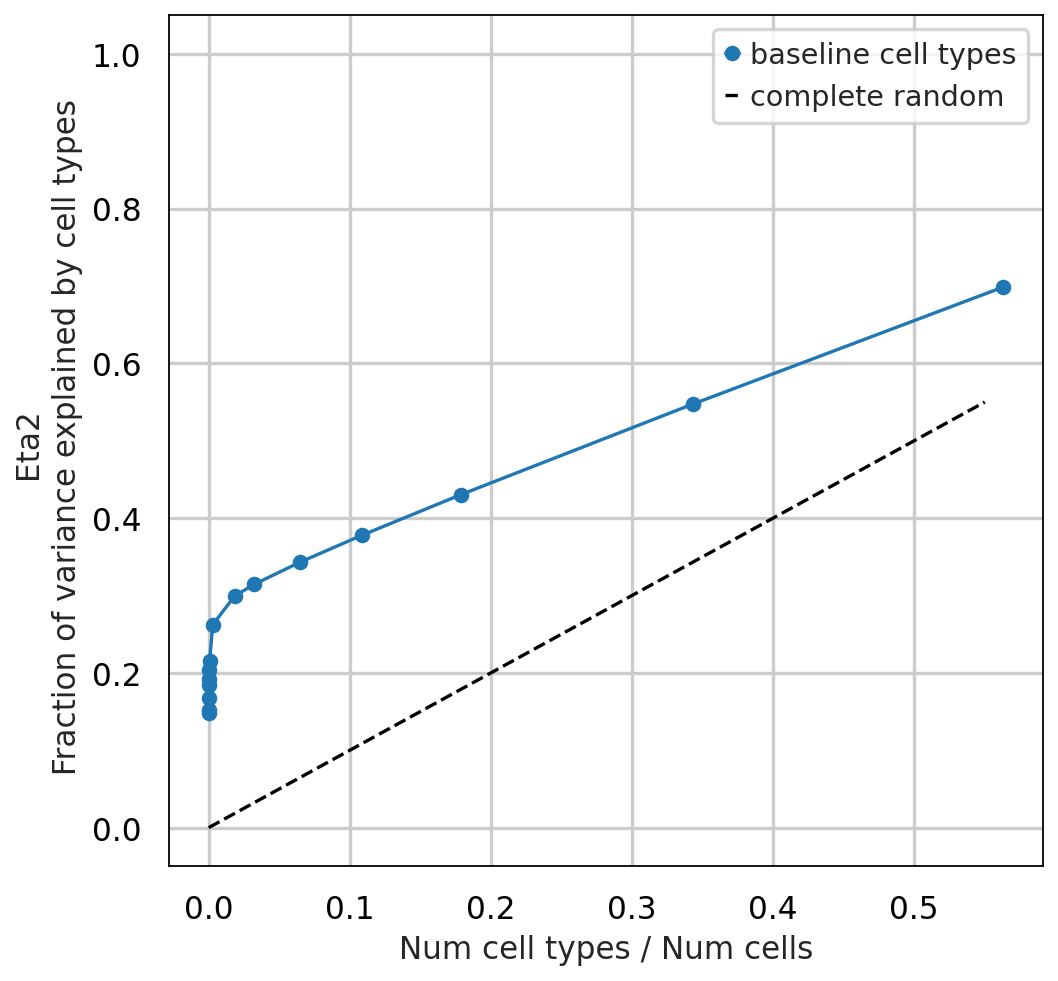

In [46]:
# summary plot (nclst vs eta^2)
ncells = len(adata)

fig, ax = plt.subplots()
ax.plot(np.array(nclsts)/ncells, overall_scores, '-o', label='baseline cell types')
ax.plot([0, 0.55], [0, 0.55], '--k', label='complete random')
ax.set_ylim([-0.05, 1.05])
ax.legend()
ax.set_ylabel('Eta2 \n Fraction of variance explained by cell types')
ax.set_xlabel('Num cell types / Num cells')
# ax.set_xlim([10, 1.2*nclsts[-1]])
# ax.set_xscale('log')
plt.show()

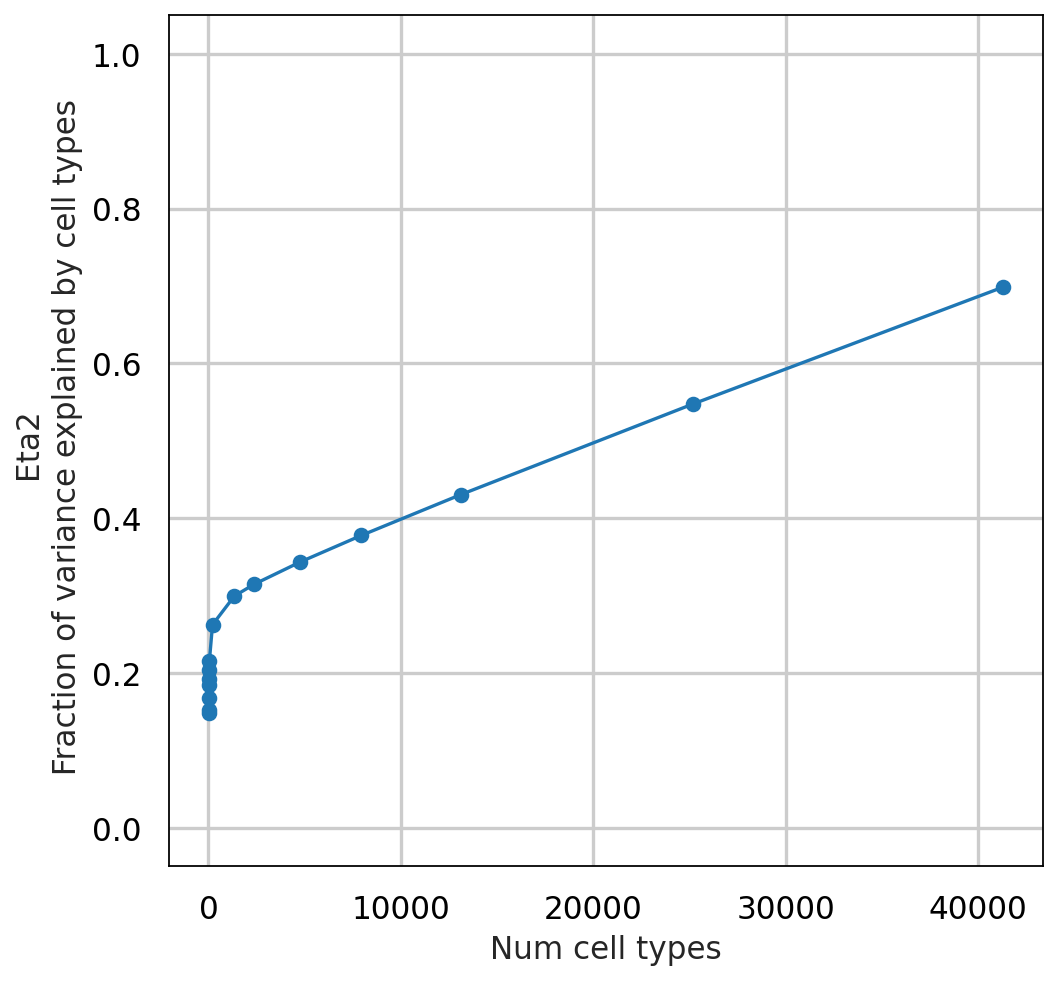

In [17]:
# summary plot (nclst vs eta^2)
ncells = len(adata)

fig, ax = plt.subplots()
ax.plot(np.array(nclsts), overall_scores, '-o')
ax.set_ylim([-0.05, 1.05])
ax.set_ylabel('Eta2 \n Fraction of variance explained by cell types')
ax.set_xlabel('Num cell types')
# ax.set_xlim([10, 1.2*nclsts[-1]])
# ax.set_xscale('log')
plt.show()

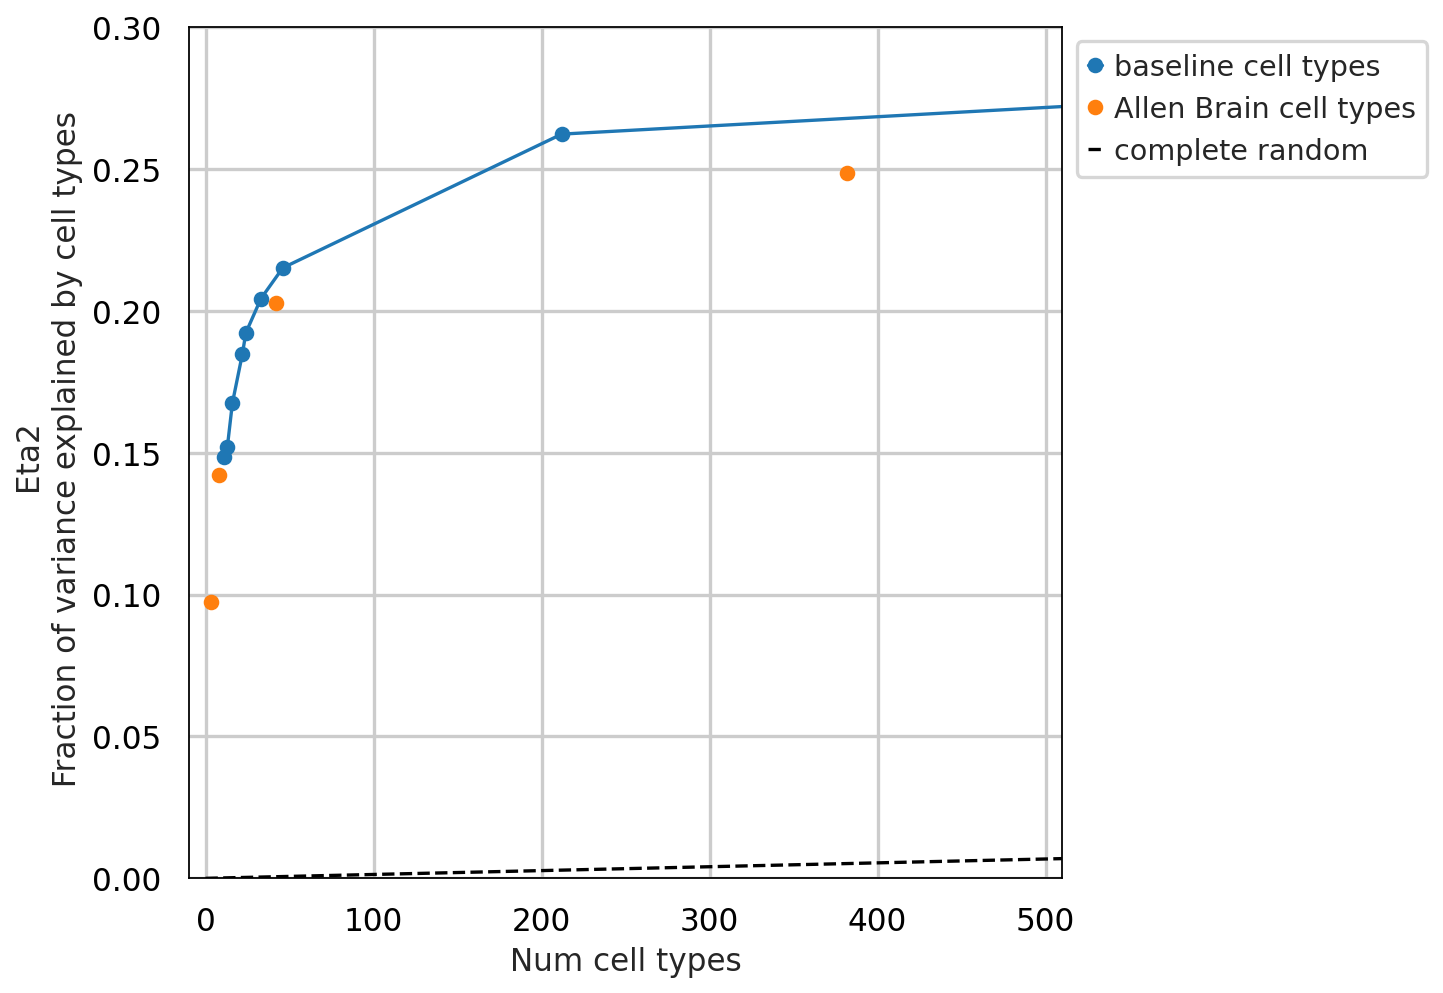

In [44]:
# summary plot (nclst vs eta^2)
ncells = len(adata)

fig, ax = plt.subplots()
ax.plot(np.array(nclsts), overall_scores, '-o', label='baseline cell types')
ax.plot(allen_nclsts, allen_overall_scores, 'o', label='Allen Brain cell types')
ax.plot([0, 0.1*ncells], [0, 0.1], '--k', label='complete random')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

ax.set_ylim(ymin=0, ymax=0.3)
ax.set_xlim(xmin=-10, xmax=510)
ax.set_ylabel('Eta2 \n Fraction of variance explained by cell types')
ax.set_xlabel('Num cell types')
plt.show()

In [ ]:
# what is random???

# baseline gene reconstruction

In [19]:
def get_mse(y_true, y_pred):
    """
    """
    mse = np.power(y_true-y_pred, 2).mean()
    return mse

def get_r2(y_true, y_pred):
    """
    """
    # r2 = 1-(np.power(y_true-y_pred, 2).mean()/np.power(y_true-np.mean(y_true, axis=0), 2).mean())
    r2 = 1 - np.linalg.norm(y_true-y_pred)**2/np.linalg.norm(y_true-np.mean(y_true, axis=0))**2
    return r2

In [20]:
%%time
np.random.seed(0)
n_splits = 2
n_k = 5

kf = KFold(n_splits=n_splits, shuffle=True)
for train_idx, test_idx in kf.split(X):
    X_train = X[train_idx, :]
    X_test = X[test_idx, :]
    y_train = y[train_idx, :]
    y_test = y[test_idx, :]

    model = NearestNeighbors(n_neighbors=n_k, metric='euclidean', algorithm='ball_tree')
    model.fit(X_train)
    # test (row) by train (col)
    knn = model.kneighbors_graph(X_test)
    y_pred = knn.dot(y_train)/n_k
    
    # eval
    mse = get_mse(y_test, y_pred)
    r2 = get_r2(y_test, y_pred)
    print(mse, r2)

    break


0.33296903779015535 0.13685720354781372
CPU times: user 1min 11s, sys: 4.22 s, total: 1min 15s
Wall time: 1min 5s


In [21]:
%%time
corr_cell = basicu.corr_paired_rows_fast(y_pred, y_test)
corr_gene = basicu.corr_paired_rows_fast(y_pred.T, y_test.T)
print(corr_cell.shape, corr_gene.shape)

/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/basicu.py:52: RuntimeWarning:

invalid value encountered in true_divide

/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/basicu.py:53: RuntimeWarning:

invalid value encountered in true_divide



(36674,) (5576,)
CPU times: user 14.3 s, sys: 42 s, total: 56.3 s
Wall time: 52.4 s


In [22]:
corr_cell = np.nan_to_num(corr_cell, 0)
corr_gene = np.nan_to_num(corr_gene, 0)

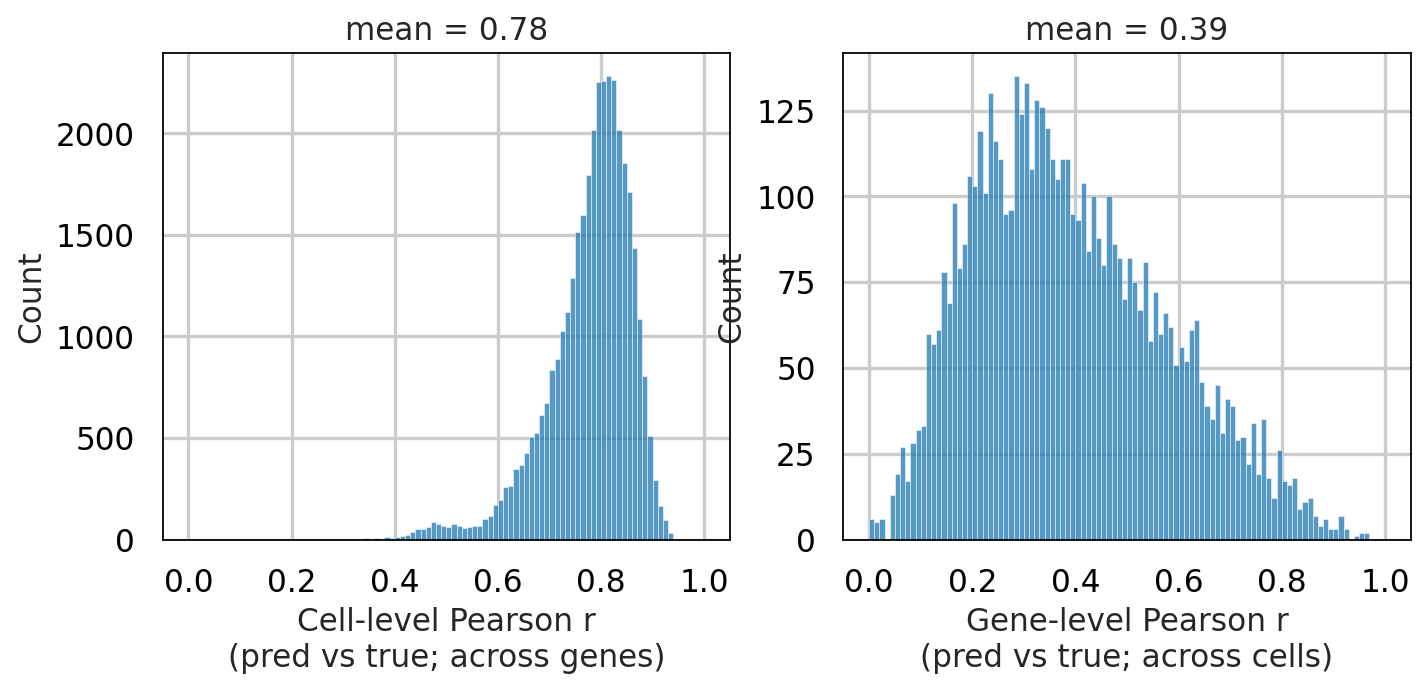

In [23]:
bins = np.linspace(0, 1, 101)
fig, axs = plt.subplots(1, 2, figsize=(5*2,4))
ax = axs[0]
sns.histplot(corr_cell, bins=bins, ax=ax)
corr_meancell = np.mean(corr_cell)
ax.set_xlabel('Cell-level Pearson r\n(pred vs true; across genes)')
ax.set_title(f'mean = {corr_meancell:.2f}')

ax = axs[1]
sns.histplot(corr_gene, bins=bins, ax=ax)
corr_meangene = np.mean(corr_gene)
ax.set_xlabel('Gene-level Pearson r\n(pred vs true; across cells)')
ax.set_title(f'mean = {corr_meangene:.2f}')

plt.show()

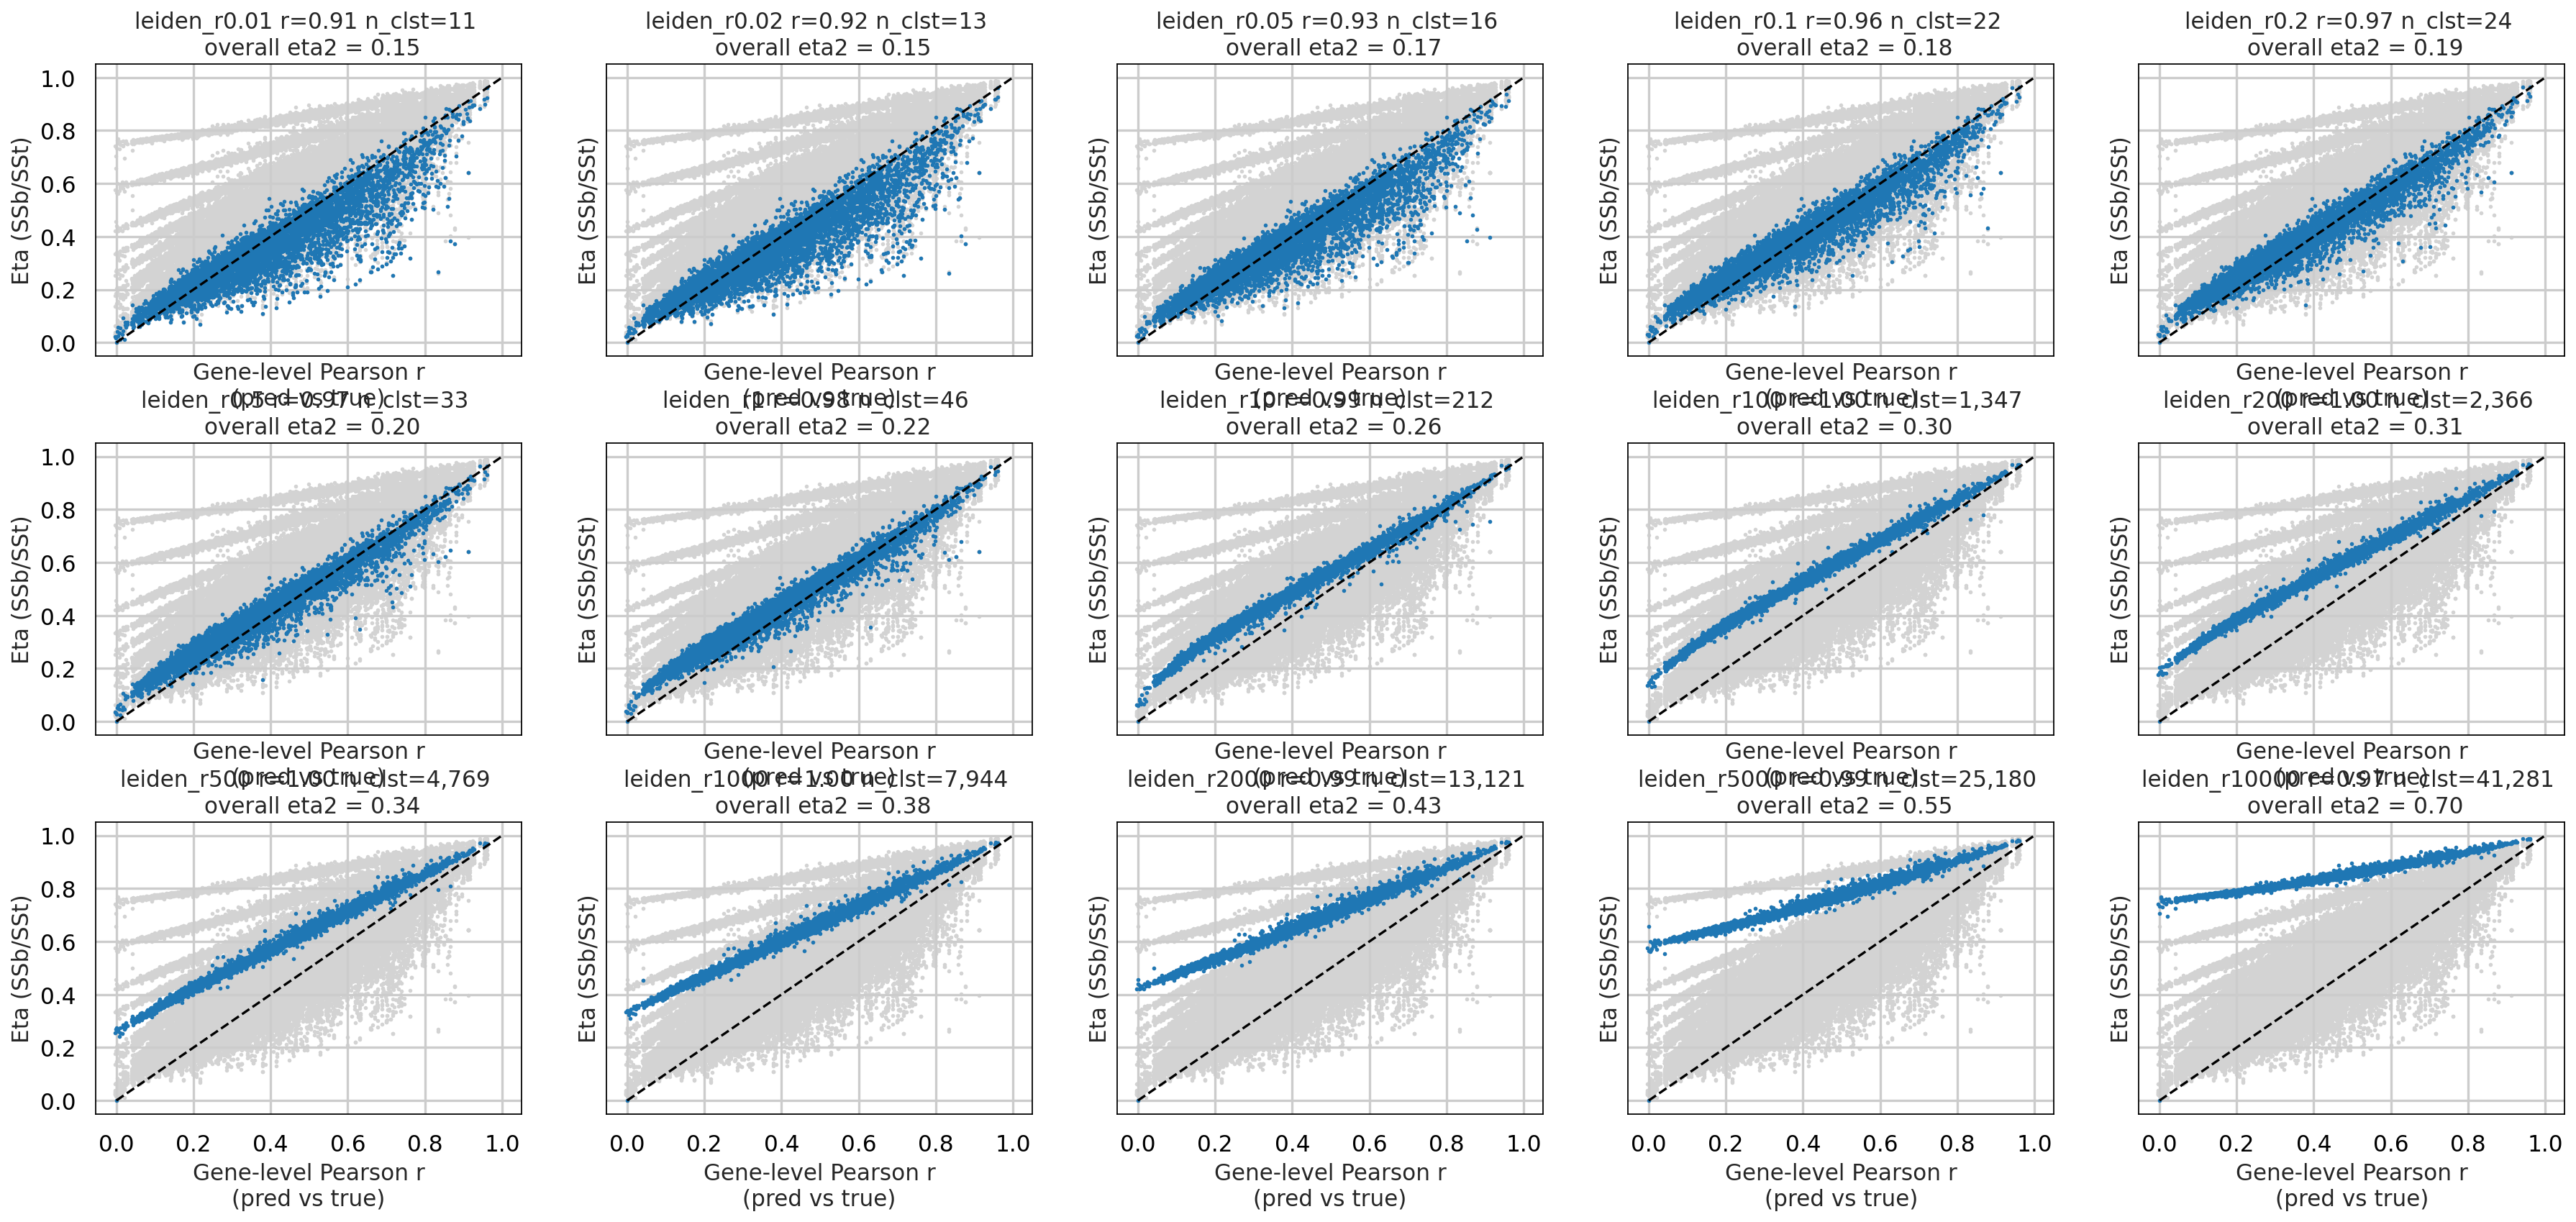

In [30]:
n = len(etas)
nx = 5
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny, nx, figsize=(5.5*nx, 4*ny), sharex=True, sharey=True)
for i, (eta, label, overall_score, nclst, ax) in enumerate(zip(etas, labels, overall_scores, nclsts, axs.flat)):
    
    cond = ~np.isnan(corr_gene)
    r, p = stats.pearsonr(corr_gene[cond], eta[cond])
    # r, p = stats.spearmanr(corr_gene, eta, nan_policy='omit')
    ax.scatter(corr_gene, eta, s=1) #, color=f'C{i}')
    
    for eta in etas:
        ax.scatter(corr_gene, eta, s=1, color='lightgray', zorder=0)
    
    # ax.legend()
    ax.plot([0,1], [0,1], '--k')
    ax.set_title(f"{label} r={r:.2f} n_clst={nclst:,} \n overall eta2 = {overall_score:.2f}")
    ax.set_xlabel('Gene-level Pearson r\n(pred vs true)')
    ax.set_ylabel('Eta (SSb/SSt)')
fig.subplots_adjust(wspace=0.2, hspace=0.3)
plt.show()